<a target="_blank" href="https://colab.research.google.com/github/santineiraher/HE2_Consultor-a_IA_Responsable/blob/main/Semana%2005/scripts/HE2_boosting_clasificacion.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# HE2 Semana 05: Árboles, Random Forest y XGBoost con SHAP

Práctica de clasificación supervisada usando la misma fuente de datos de Semana 04 (`adult.csv`), pero enfocada en modelos de árboles y ensambles.

**Objetivos del cuaderno**
- Implementar **CART**, **Random Forest** y **XGBoost**.
- Evaluar desempeño con métricas de clasificación (`accuracy`, `precision`, `recall`, `f1`, `roc_auc`).
- Hacer tuning con **GridSearchCV** y **RandomizedSearchCV**.
- Enfatizar interpretabilidad con **SHAP**: beeswarm, cascada (waterfall) y feature importance.



In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from IPython.display import display
from scipy import sparse

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

try:
    from xgboost import XGBClassifier
except ImportError:
    raise ImportError("No se encontró `xgboost`. Instálalo con: pip install xgboost")

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

TARGET_COL = "income"
RANDOM_STATE = 1999
TEST_SIZE = 0.2
SCORING_MAIN = "f1"
N_ITER_RANDOM_SEARCH = 20

print("Configuración cargada.")
print({
    "TARGET_COL": TARGET_COL,
    "RANDOM_STATE": RANDOM_STATE,
    "TEST_SIZE": TEST_SIZE,
    "SCORING_MAIN": SCORING_MAIN,
    "N_ITER_RANDOM_SEARCH": N_ITER_RANDOM_SEARCH,
})

Configuración cargada.
{'TARGET_COL': 'income', 'RANDOM_STATE': 1999, 'TEST_SIZE': 0.2, 'SCORING_MAIN': 'f1', 'N_ITER_RANDOM_SEARCH': 20}


## 1. Carga de datos

Usamos exactamente la misma fuente del notebook de clasificación de Semana 04.

## 2. Limpieza mínima y definición del target

- Reemplazamos el marcador de faltantes (`" ?"`) por `NaN`.
- Eliminamos filas incompletas.
- Convertimos `income` a objetivo binario: `0` para `<=50K`, `1` para `>50K`.

In [7]:
url = "https://raw.githubusercontent.com/DataResponsibly/Datasets/master/AdultIncomeData/adult.csv"
df_raw = pd.read_csv(url)
df = df_raw.copy()

missing_token = " ?"
df = df.replace(missing_token, np.nan)

print("Filas con faltantes antes de dropna:", df.isna().any(axis=1).sum())
df = df.dropna().copy()
print("Shape luego de dropna:", df.shape)

income_clean = (
    df[TARGET_COL]
    .astype(str)
    .str.strip()
    .str.replace(".", "", regex=False)
)
y = income_clean.str.contains(r">50K").astype(int)
X = df.drop(columns=[TARGET_COL])

print("Valores únicos de y:", sorted(y.unique().tolist()))
if set(y.unique()) != {0, 1}:
    raise ValueError("El target binario no quedó en {0,1}.")

print("Balance de clases (proporción):")
display(y.value_counts(normalize=True).rename("proportion").to_frame())

if X.isna().sum().sum() > 0:
    raise ValueError("Quedaron NaN en X después de la limpieza.")

print("OK: limpieza validada (sin NaN en X, y binaria).")

Filas con faltantes antes de dropna: 2399
Shape luego de dropna: (30162, 15)
Valores únicos de y: [0, 1]
Balance de clases (proporción):


,proportion
income,
0,0.751078
1,0.248922


OK: limpieza validada (sin NaN en X, y binaria).


## 3. Train/Test split

Hacemos partición estratificada para conservar la proporción de clases en train y test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Tamaños:")
print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("y_train mean:", y_train.mean().round(4), "| y_test mean:", y_test.mean().round(4))

Tamaños:
X_train: (24129, 14) | X_test: (6033, 14)
y_train mean: 0.2489 | y_test mean: 0.249


## 4. Preprocesamiento reusable

Como trabajamos con árboles y ensambles, no necesitamos escalar variables numéricas para que el modelo funcione bien. Sí necesitamos codificación para variables categóricas (`OneHotEncoder`).

In [9]:
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

print("Numéricas:", len(numeric_features))
print("Categóricas:", len(categorical_features))

# Compatibilidad entre versiones de scikit-learn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

display(pd.DataFrame({
    "numeric_features": pd.Series(numeric_features),
    "categorical_features": pd.Series(categorical_features),
}))

Numéricas: 6
Categóricas: 8


,numeric_features,categorical_features
0,age,workclass
1,fnlwgt,education
2,education-num,marital-status
3,capital-gain,occupation
4,capital-loss,relationship
5,hours-per-week,race
6,NaN,sex
7,NaN,native-country


## 5. Funciones auxiliares (métricas)

Definimos funciones para evitar repetir lógica de evaluación y mantener el cuaderno ordenado.

In [10]:
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
    }


def fit_and_eval(name, estimator, X_train, y_train, X_test, y_test):
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", estimator),
    ])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    metrics_dict = evaluate_model(y_test, y_pred, y_prob)
    metrics_dict["model"] = name
    return pipe, metrics_dict

## 6. Modelos base: CART, Random Forest y XGBoost

Entrenamos los tres modelos con hiperparámetros razonables para obtener una línea base comparable.

In [11]:
models = {
    "cart": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
    "xgb": XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_estimators=300,
        learning_rate=0.08,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1,
    ),
}

base_results = []
base_confusions = {}
fitted_base_models = {}

for model_name, model_obj in models.items():
    pipe, metrics_dict = fit_and_eval(model_name, model_obj, X_train, y_train, X_test, y_test)
    base_results.append(metrics_dict)
    fitted_base_models[model_name] = pipe

    y_pred = pipe.predict(X_test)
    base_confusions[model_name] = confusion_matrix(y_test, y_pred)

base_results_df = pd.DataFrame(base_results).sort_values("f1", ascending=False).reset_index(drop=True)
print("Resultados base (ordenados por F1):")
display(base_results_df)

Resultados base (ordenados por F1):


,accuracy,precision,recall,f1,roc_auc,model
0,0.873363,0.786936,0.673768,0.725968,0.931361,xgb
1,0.857948,0.747506,0.648469,0.694474,0.907111,rf
2,0.815846,0.623813,0.655792,0.639403,0.762420,cart


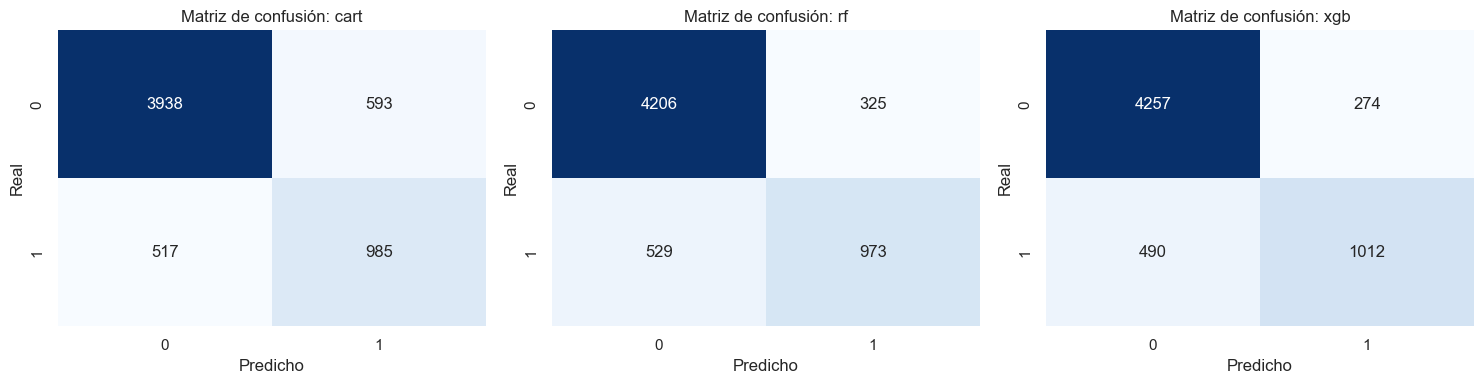

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, model_name in zip(axes, ["cart", "rf", "xgb"]):
    cm = base_confusions[model_name]
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", ax=ax)
    ax.set_title(f"Matriz de confusión: {model_name}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
plt.tight_layout()
plt.show()

## 7. Visualización del árbol CART

Mostramos los primeros niveles para que sea legible (un árbol completo puede ser muy grande).

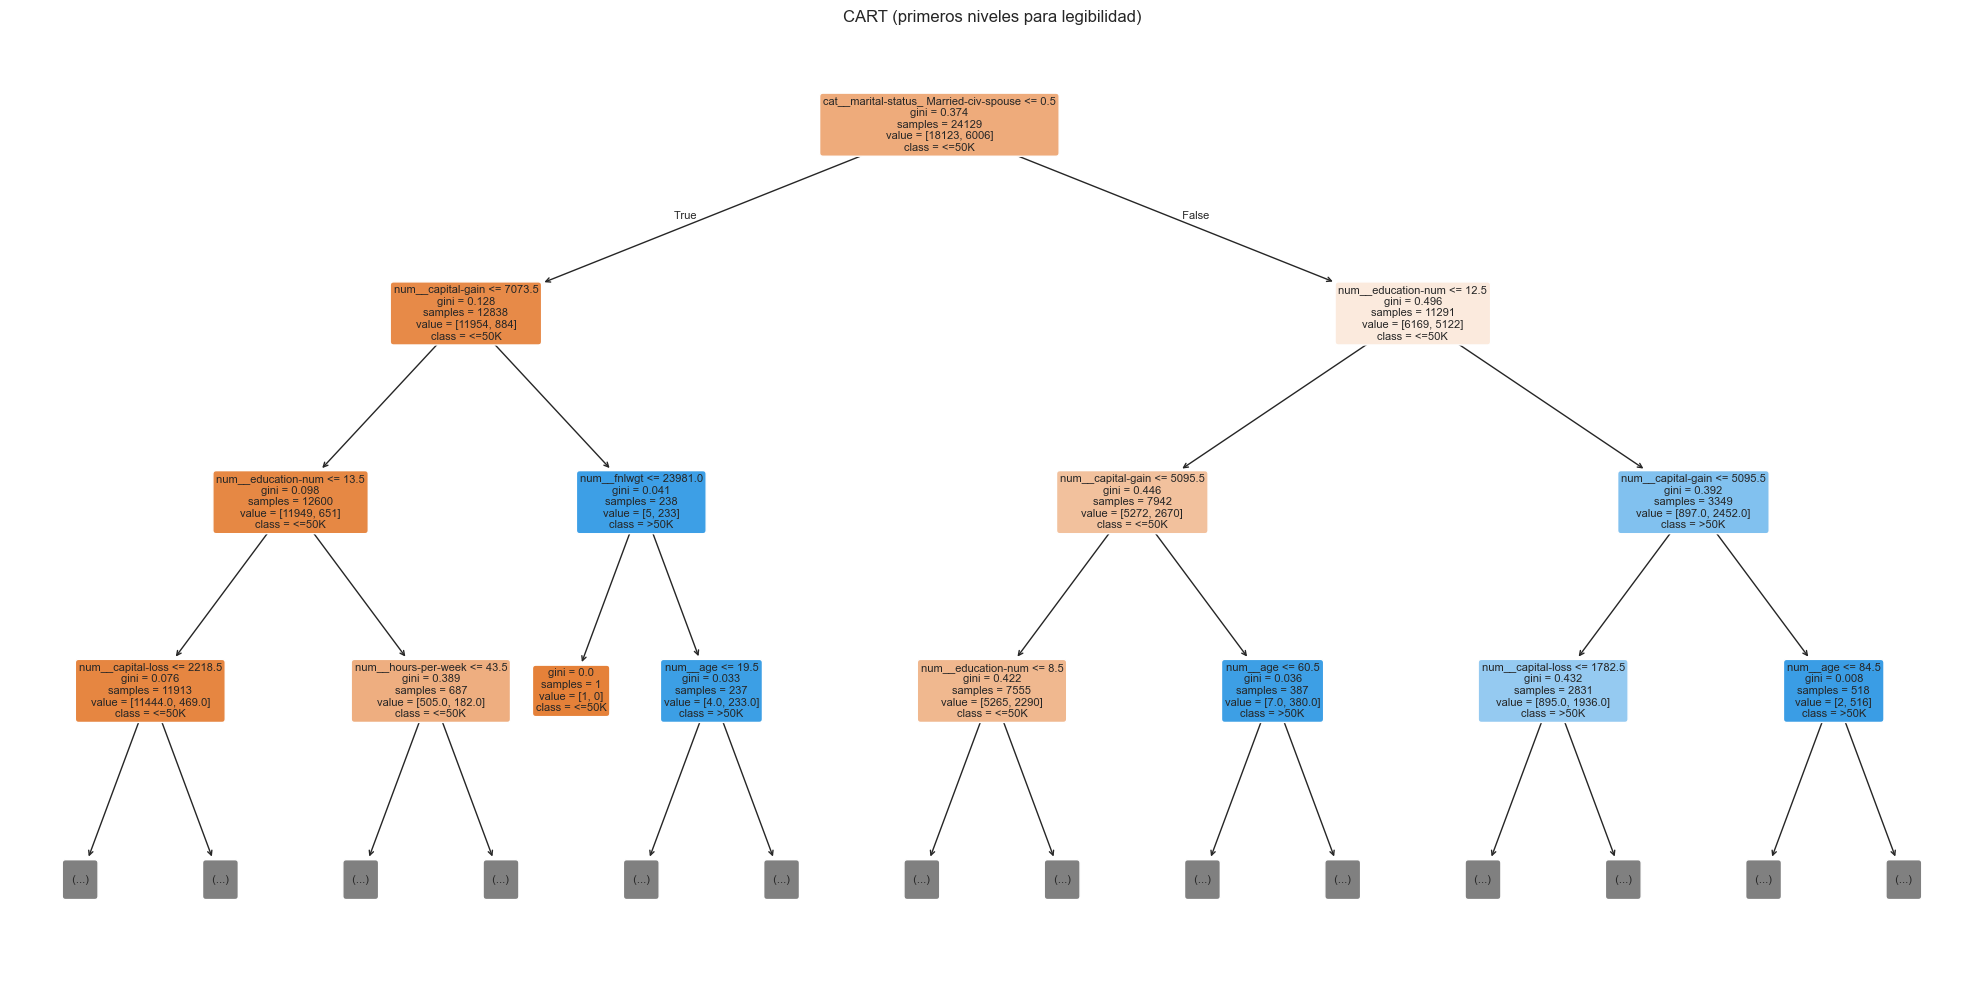

In [13]:
cart_pipe = fitted_base_models["cart"]
cart_model = cart_pipe.named_steps["model"]
feature_names = cart_pipe.named_steps["preprocess"].get_feature_names_out()

plt.figure(figsize=(20, 10))
plot_tree(
    cart_model,
    max_depth=3,
    feature_names=feature_names,
    class_names=["<=50K", ">50K"],
    filled=True,
    rounded=True,
    fontsize=8,
)
plt.title("CART (primeros niveles para legibilidad)")
plt.tight_layout()
plt.show()

## 8. Tuning de hiperparámetros

Usamos dos estrategias:

- **GridSearchCV** para CART (espacio relativamente pequeño y fácil de recorrer).
- **RandomizedSearchCV** para RF y XGBoost (espacios de búsqueda más grandes).

La métrica principal de selección es `F1`, para balancear `precision` y `recall`.

In [21]:
print("Iniciando tuning de hiperparámetros...")

# 8.1 GridSearch para CART
cart_pipe_grid = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

cart_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [3, 5, 8, 12, None],
    "model__min_samples_split": [2, 10, 30],
    "model__min_samples_leaf": [1, 5, 15],
    "model__ccp_alpha": [0.0, 0.001, 0.005],
}

grid_cart = GridSearchCV(
    estimator=cart_pipe_grid,
    param_grid=cart_grid,
    scoring=SCORING_MAIN,
    cv=5,
    n_jobs=-1,
    refit=True,
)
grid_cart.fit(X_train, y_train)

# 8.2 RandomizedSearch para RF
rf_pipe_random = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)),
])

rf_distributions = {
    "model__n_estimators": [200, 400, 600, 900],
    "model__max_depth": [None, 8, 12, 16, 22],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.4, 0.7],
}

random_rf = RandomizedSearchCV(
    estimator=rf_pipe_random,
    param_distributions=rf_distributions,
    n_iter=N_ITER_RANDOM_SEARCH,
    scoring=SCORING_MAIN,
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True,
)
random_rf.fit(X_train, y_train)

# 8.3 RandomizedSearch para XGBoost
xgb_pipe_random = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )),
])

xgb_distributions = {
    "model__n_estimators": [200, 350, 500, 700],
    "model__learning_rate": [0.03, 0.05, 0.08, 0.12],
    "model__max_depth": [3, 4, 5, 6, 8],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.75, 0.9, 1.0],
    "model__min_child_weight": [1, 3, 5, 8],
    "model__gamma": [0.0, 0.1, 0.3],
    "model__reg_lambda": [0.5, 1.0, 2.0],
}

random_xgb = RandomizedSearchCV(
    estimator=xgb_pipe_random,
    param_distributions=xgb_distributions,
    n_iter=N_ITER_RANDOM_SEARCH,
    scoring=SCORING_MAIN,
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True,
    verbose=2
)
random_xgb.fit(X_train, y_train)

print("Tuning finalizado.")

Iniciando tuning de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning finalizado.


In [15]:
search_objects = {
    "cart_grid": grid_cart,
    "rf_random": random_rf,
    "xgb_random": random_xgb,
}

tuning_results = []
best_estimators = {}

for search_name, search_obj in search_objects.items():
    best_pipe = search_obj.best_estimator_
    y_prob = best_pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    m = evaluate_model(y_test, y_pred, y_prob)
    m.update({
        "search": search_name,
        "best_cv_f1": search_obj.best_score_,
        "best_params": search_obj.best_params_,
    })
    tuning_results.append(m)
    best_estimators[search_name] = best_pipe

tuning_results_df = pd.DataFrame(tuning_results).sort_values("f1", ascending=False).reset_index(drop=True)

print("Resultados tuned (ordenados por F1 en test):")
display(tuning_results_df[["search", "best_cv_f1", "accuracy", "precision", "recall", "f1", "roc_auc"]])

print("Mejores hiperparámetros por búsqueda:")
for _, row in tuning_results_df.iterrows():
    print(f"- {row['search']}: {row['best_params']}")

Resultados tuned (ordenados por F1 en test):


,search,best_cv_f1,accuracy,precision,recall,f1,roc_auc
0,xgb_random,0.715328,0.874523,0.791243,0.673768,0.727796,0.931096
1,rf_random,0.689296,0.862258,0.770346,0.636485,0.697047,0.915093
2,cart_grid,0.671433,0.855130,0.778369,0.584554,0.667681,0.898188


Mejores hiperparámetros por búsqueda:
- xgb_random: {'model__subsample': 0.9, 'model__reg_lambda': 1.0, 'model__n_estimators': 350, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__gamma': 0.0, 'model__colsample_bytree': 0.9}
- rf_random: {'model__n_estimators': 400, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.7, 'model__max_depth': None}
- cart_grid: {'model__ccp_alpha': 0.0, 'model__criterion': 'entropy', 'model__max_depth': 12, 'model__min_samples_leaf': 15, 'model__min_samples_split': 2}


## 9. SHAP intensivo: explicación global e individual

Aquí insistimos en SHAP como pediste:

1. **Beeswarm** (impacto global + dirección del efecto).  
2. **Feature importance SHAP** (promedio de `|SHAP|`).  
3. **Cascada / Waterfall** (explicación local de una observación).  
4. **Dependence plot** para una de las variables más influyentes.

> Recomendación: correr estas celdas después del tuning para explicar el mejor modelo.

In [22]:
best_row = tuning_results_df.iloc[0]
best_search_name = best_row["search"]
best_pipe = best_estimators[best_search_name]
best_model = best_pipe.named_steps["model"]
best_preprocess = best_pipe.named_steps["preprocess"]

print(f"Mejor modelo tuned por F1 en test: {best_search_name}")

X_train_proc = best_preprocess.transform(X_train)
X_test_proc = best_preprocess.transform(X_test)
feature_names = best_preprocess.get_feature_names_out()

if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()
if sparse.issparse(X_test_proc):
    X_test_proc = X_test_proc.toarray()

# Submuestra para acelerar SHAP si el set es grande
n_shap = min(1500, X_test_proc.shape[0])
idx_eval = np.random.RandomState(RANDOM_STATE).choice(X_test_proc.shape[0], size=n_shap, replace=False)
X_eval_proc = X_test_proc[idx_eval]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_eval_proc)

if isinstance(shap_values, list):
    shap_values_for_class_1 = shap_values[1]
    expected_value = explainer.expected_value[1]
else:
    shap_values_for_class_1 = shap_values
    expected_value = explainer.expected_value

print("SHAP preparado para visualización.")

Mejor modelo tuned por F1 en test: xgb_random
SHAP preparado para visualización.


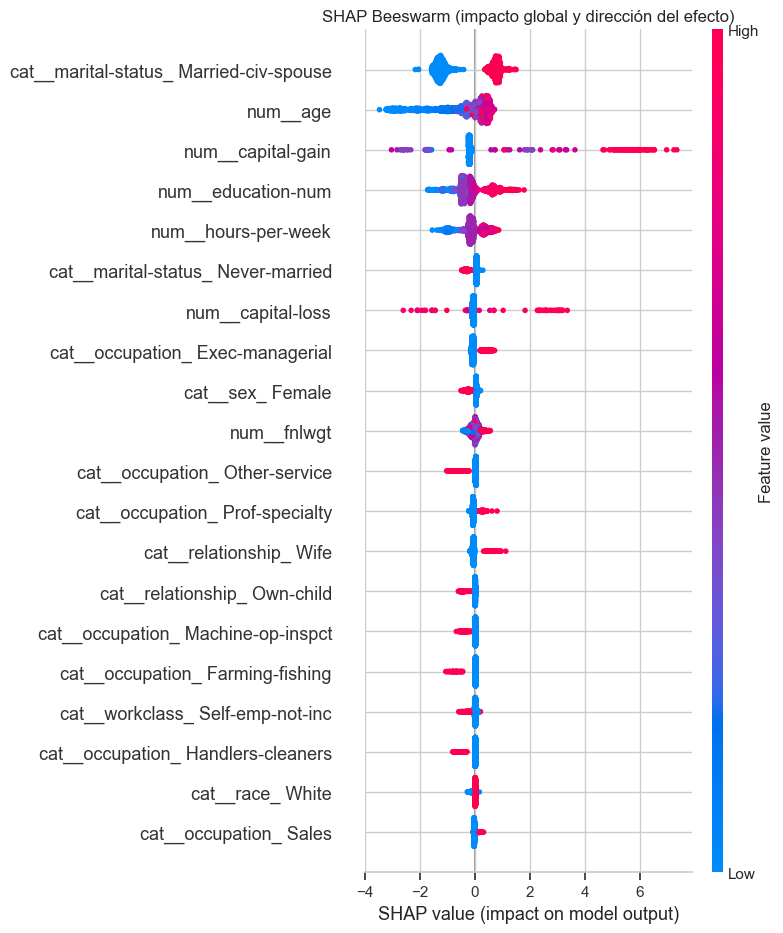

In [23]:
# 9.1 SHAP Beeswarm
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_for_class_1,
    X_eval_proc,
    feature_names=feature_names,
    show=False,
)
plt.title("SHAP Beeswarm (impacto global y dirección del efecto)")
plt.tight_layout()
plt.show()

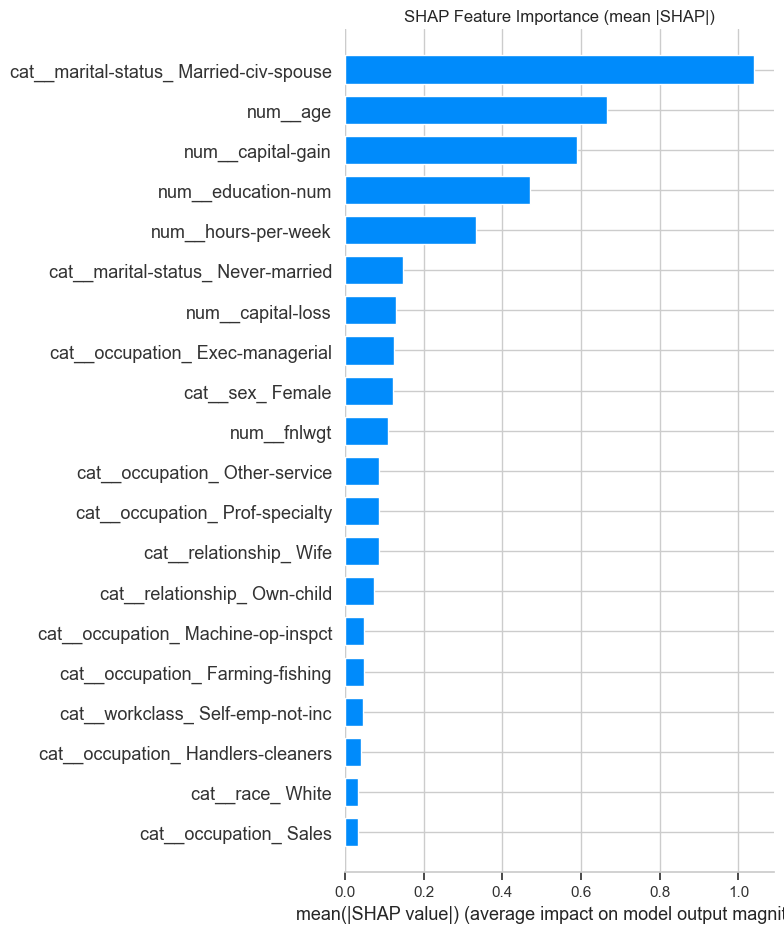

In [24]:
# 9.2 SHAP Feature Importance (bar)
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_for_class_1,
    X_eval_proc,
    feature_names=feature_names,
    plot_type="bar",
    show=False,
)
plt.title("SHAP Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()

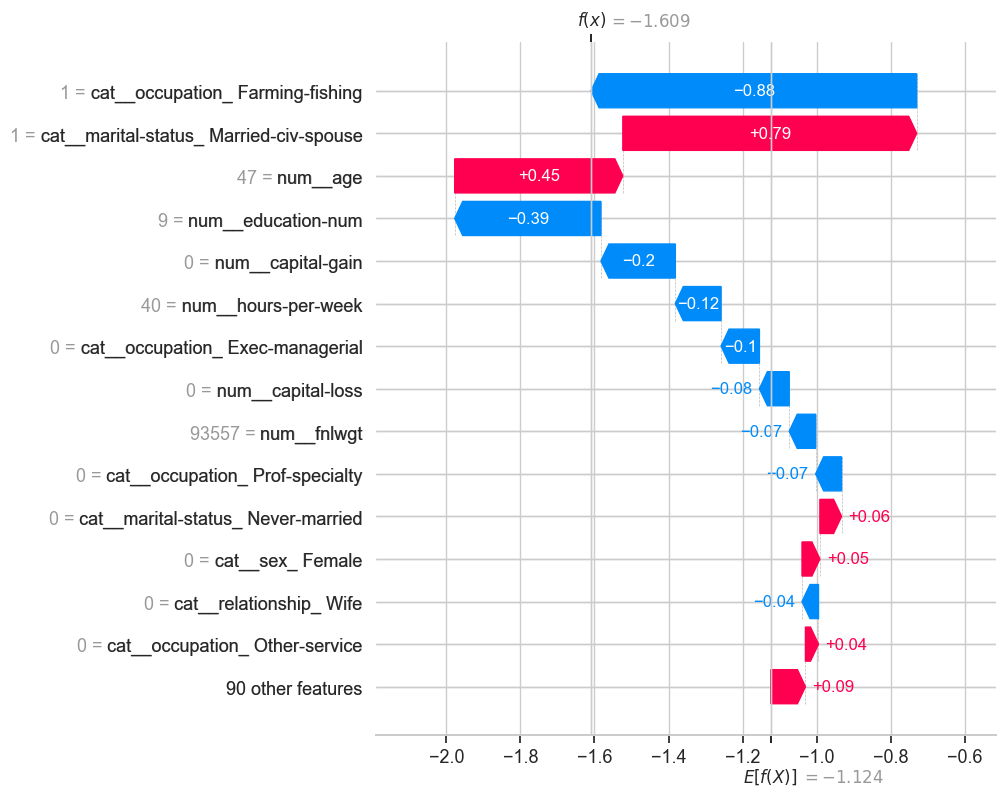

In [25]:
# 9.3 SHAP Cascada / Waterfall (explicación local)
idx_local = 0
local_explanation = shap.Explanation(
    values=shap_values_for_class_1[idx_local],
    base_values=expected_value,
    data=X_eval_proc[idx_local],
    feature_names=feature_names,
)

# Nota: en algunos entornos, waterfall maneja internamente la figura.
shap.plots.waterfall(local_explanation, max_display=15)

Variable con mayor impacto SHAP promedio: cat__marital-status_ Married-civ-spouse


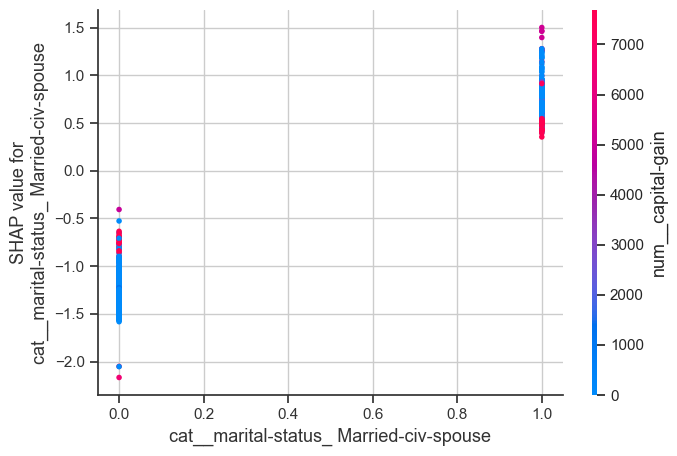

In [20]:
# 9.4 SHAP Dependence Plot (complemento recomendado)
mean_abs_shap = np.abs(shap_values_for_class_1).mean(axis=0)
top_idx = int(np.argmax(mean_abs_shap))
top_feature = feature_names[top_idx]

print("Variable con mayor impacto SHAP promedio:", top_feature)

shap.dependence_plot(
    top_idx,
    shap_values_for_class_1,
    X_eval_proc,
    feature_names=feature_names,
    interaction_index="auto",
)

### Aclaración importante sobre el valor `f(x)` en SHAP

En modelos como XGBoost, el waterfall suele mostrar `f(x)` en **log-odds** (margen del modelo), no en probabilidad.

- Por eso `f(x)` puede ser negativo o mayor que 1.
- Para llevarlo a probabilidad de clase 1 usamos la sigmoide:

\[
P(y=1) = \frac{1}{1 + e^{-f(x)}}
\]

La siguiente celda hace esa conversión y reporta también la clase predicha con umbral 0.5.

In [18]:
# Conversión de f(x) (log-odds) a probabilidad
fx_log_odds = local_explanation.base_values + local_explanation.values.sum()
prob_clase_1 = 1 / (1 + np.exp(-fx_log_odds))
clase_predicha = int(prob_clase_1 >= 0.5)

print(f"f(x) en log-odds: {fx_log_odds:.4f}")
print(f"Probabilidad clase 1 (>50K): {prob_clase_1:.4f}")
print(f"Clase predicha (umbral=0.5): {clase_predicha}")

f(x) en log-odds: -1.7011
Probabilidad clase 1 (>50K): 0.1543
Clase predicha (umbral=0.5): 0


## 10. Cierre

- **CART** aporta reglas interpretables directamente en forma de árbol.
- **Random Forest** reduce varianza y suele mejorar robustez respecto a un solo árbol.
- **XGBoost** suele alcanzar mejor desempeño tras tuning cuidadoso.
- **SHAP** permite pasar de modelo de alto desempeño a explicaciones accionables, tanto globales como individuales.

Si quieres, en un siguiente paso te lo adapto para que al final imprima automáticamente un breve reporte narrativo para clase (tipo consultoría) con el mejor modelo y sus variables clave.